In [1]:
#INITIALIZE SPARK SESSION
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PodPres").getOrCreate()

assembled_df = spark.read.parquet("final_features_human_labels.parquet")
assembled_df.printSchema()
assembled_df.show() 


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 15:37:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 15:37:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/12 15:37:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/05/12 15:37:54 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


root
 |-- segment_id: long (nullable = true)
 |-- podcast_name_cleaned: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)



+----------+--------------------+--------------------+-----+
|segment_id|podcast_name_cleaned|            features|label|
+----------+--------------------+--------------------+-----+
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|    1|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.7|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.2|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.4|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.7|
|         1|    pod save america|[10.0,-0.01585099...|  0.8|
|         1|    pod save america|[10.0,-0.01585099...|  0.1|
|         1|    pod save america|[10.0,-0.01585099...|  0.9|
|         1|    pod save

In [2]:
from pyspark.sql.functions import rand

# Shuffle the DataFrame
shuffled_df = assembled_df.orderBy(rand())

In [3]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
train_df, test_df = shuffled_df.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.withColumn("label", col("label").cast(FloatType()))
test_df = test_df.withColumn("label", col("label").cast(FloatType()))

In [4]:
# Get the statistical summary for the "label" column
train_df.describe("label").show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|                727|
|   mean| 0.4993122421317776|
| stddev|0.32568988952814487|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [5]:
from pyspark.sql.functions import col, count, lit

# Calculate the total number of rows to compute proportions
total_count = train_df.count()

# Group by the 'label' column and calculate the count of each label
label_distribution = train_df.groupBy("label").count()

# Calculate the percentage of each label
label_distribution = label_distribution.withColumn("percentage", (col("count") / lit(total_count) * 100))

# Display the results
label_distribution.show()

24/05/12 15:38:05 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----+-----+------------------+
|label|count|        percentage|
+-----+-----+------------------+
|  0.1|  126| 17.33149931224209|
|  0.6|   18|2.4759284731774414|
|  0.9|   85|11.691884456671252|
|  0.5|  127| 17.46905089408528|
|  1.0|   69| 9.491059147180192|
|  0.3|   49| 6.740027510316368|
|  0.4|   28| 3.851444291609354|
|  0.8|   78|10.729023383768913|
|  0.2|   75| 10.31636863823934|
|  0.0|   33|  4.53920220082531|
|  0.7|   39| 5.364511691884457|
+-----+-----+------------------+



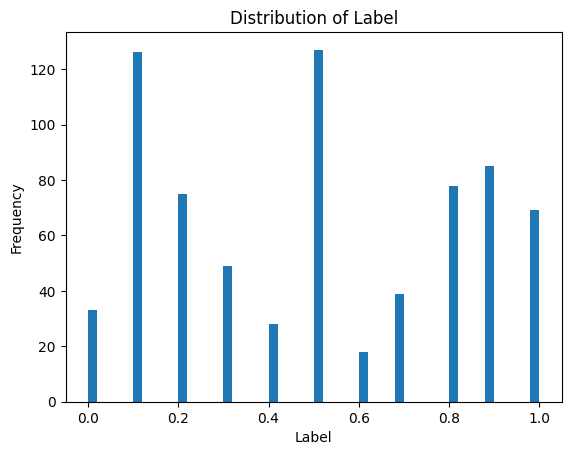

In [6]:
import matplotlib.pyplot as plt

# Retrieve the "label" data
label_data = train_df.select("label").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.hist(label_data, bins=50)  # bins参数根据数据的具体情况调整
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [7]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Fit the scaler on the entire dataset
scaler_model = scaler.fit(train_df)

# Transform the training and test data
scaled_train_df = scaler_model.transform(train_df)
scaled_test_df = scaler_model.transform(test_df)

from pyspark.ml.regression import RandomForestRegressor

# Create a Random Forest regression model, noting to specify the featuresCol as "scaled
rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="label", numTrees=20, maxDepth=5)

# model traning
rf_model = rf.fit(scaled_train_df)

In [9]:
# prediction
predictions = rf_model.transform(scaled_test_df)
predictions.select("prediction", "label").show()


+-------------------+-----+
|         prediction|label|
+-------------------+-----+
| 0.5739628570905417|  0.5|
| 0.5739628570905417|  0.8|
| 0.6461121714723178|  0.1|
| 0.6461121714723178|  0.8|
|0.44739599803732455|  0.3|
|0.44739599803732455|  0.8|
| 0.4214170581717632|  0.5|
| 0.5342050537956005|  0.5|
|0.38497186096607294|  0.6|
|0.38497186096607294|  0.7|
|0.49146790624026354|  0.1|
|0.49146790624026354|  0.1|
|0.49146790624026354|  0.5|
| 0.4916996590057347|  0.1|
| 0.4916996590057347|  0.9|
| 0.6024663286441014|  0.7|
|0.44871086283804684|  0.8|
|   0.45831437439012|  0.9|
|  0.442821710140492|  0.4|
|  0.442821710140492|  0.9|
+-------------------+-----+
only showing top 20 rows



In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

# Configure the evaluator
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Calculate evaluation metrics
rmse = evaluator_rmse.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Squared Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)


Root Mean Squared Error (RMSE) on test data = 0.325085
Mean Squared Error (MSE) on test data = 0.10568
Mean Absolute Error (MAE) on test data = 0.280929


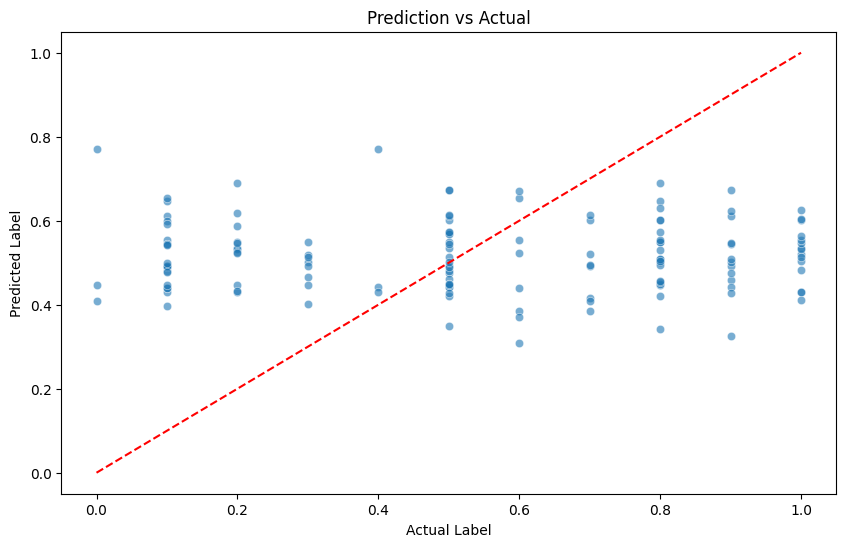

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
predictions_pd = predictions.select("label", "prediction").toPandas()

# Plot predicted values and actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='label', y='prediction', data=predictions_pd, alpha=0.6)
plt.plot([0, 1], [0, 1], '--', color='red')  # 绘制 y=x 参考线
plt.title('Prediction vs Actual')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.show()

In [12]:
from pyspark.sql.functions import col

# Calculate the winning probabilities for Trump and Biden
predictions_with_probabilities = predictions.withColumn("probability_trump", col("prediction")) \
                                            .withColumn("probability_biden", 1 - col("prediction"))

# result
predictions_with_probabilities.select("probability_trump", "probability_biden").show()


+-------------------+-------------------+
|  probability_trump|  probability_biden|
+-------------------+-------------------+
| 0.5739628570905417|0.42603714290945827|
| 0.5739628570905417|0.42603714290945827|
| 0.6461121714723178| 0.3538878285276822|
| 0.6461121714723178| 0.3538878285276822|
|0.44739599803732455| 0.5526040019626755|
|0.44739599803732455| 0.5526040019626755|
| 0.4214170581717632| 0.5785829418282368|
| 0.5342050537956005|0.46579494620439954|
|0.38497186096607294| 0.6150281390339271|
|0.38497186096607294| 0.6150281390339271|
|0.49146790624026354| 0.5085320937597364|
|0.49146790624026354| 0.5085320937597364|
|0.49146790624026354| 0.5085320937597364|
| 0.4916996590057347| 0.5083003409942652|
| 0.4916996590057347| 0.5083003409942652|
| 0.6024663286441014|0.39753367135589857|
|0.44871086283804684| 0.5512891371619532|
|   0.45831437439012|   0.54168562560988|
|  0.442821710140492|  0.557178289859508|
|  0.442821710140492|  0.557178289859508|
+-------------------+-------------

In [13]:
from pyspark.sql.functions import avg

# Calculate the average value of the 'prediction' column
trump_win_probability = predictions_with_probabilities.agg(avg("probability_trump")).first()[0]
biden_win_probability = predictions_with_probabilities.agg(avg("probability_biden")).first()[0]

# Output the probability 
print(f"Trumo Win Probability: {trump_win_probability:.2f}")
print(f"Biden Win Probability: {biden_win_probability:.2f}")

Trumo Win Probability: 0.52
Biden Win Probability: 0.48
